In [1]:
import baryonification as bfc

from scipy.interpolate import splrep, splev
from scipy.integrate import quad
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cvir_fct(mvir):
    """
    Concentrations form Dutton+Maccio (2014)
    c200 (200 times RHOC)
    Assumes PLANCK coismology
    """
    A = 1.025
    B = 0.097
    return 10.0**A*(mvir/1.0e12)**(-B)

def DeltaSigmas_from_density_profile(rbin,dens):
    
    dbin = rbin
    Sig_DMO   = []
    Sig_DMB   = []
    avSig_DMO = []
    avSig_DMB = []


    densDMO_tck = splrep(rbin,dens['DMO'])
    densDMB_tck = splrep(rbin,dens['DMB'])

    for i in range(len(dbin)):
        itgDMO   = lambda zz: splev((zz**2.0+dbin[i]**2.0)**0.5,densDMO_tck,ext=0)
        Sig_DMO += [2.0*quad(itgDMO,0,max(dbin),limit=200)[0]]
        itgDMB   = lambda zz: splev((zz**2.0+dbin[i]**2.0)**0.5,densDMB_tck,ext=0)
        Sig_DMB += [2.0*quad(itgDMB,min(dbin),max(dbin),limit=200)[0]]

    Sig_DMO = np.array(Sig_DMO)
    Sig_DMB = np.array(Sig_DMB)


    cumSigDMO_tck = splrep(dbin, Sig_DMO)
    cumSigDMB_tck = splrep(dbin, Sig_DMB)

    for i in range(len(dbin)):
        itgDMO = lambda dd: dd*splev(dd,cumSigDMO_tck)
        avSig_DMO += [quad(itgDMO,0,dbin[i])[0]*2.0/dbin[i]**2.0]
        itgDMB = lambda dd: dd*splev(dd,cumSigDMB_tck)
        avSig_DMB += [quad(itgDMB,0,dbin[i])[0]*2.0/dbin[i]**2.0]

    avSig_DMO = np.array(avSig_DMO)
    avSig_DMB = np.array(avSig_DMB)
    
    
    deltaSigmaDMO = avSig_DMO-Sig_DMO   #(Msun/h) / Mpc^2
    deltaSigmaDMB = avSig_DMB-Sig_DMB
    
    return deltaSigmaDMB, deltaSigmaDMO, deltaSigmaDMB / deltaSigmaDMO


In [3]:
par = bfc.par()

par.baryon.eta_tot = 0.32
par.baryon.eta_cga = 0.6

par.files.transfct = '/Users/fardila/Documents/GitHub/baryonification/baryonification/files/CDM_PLANCK_tk.dat'

In [4]:
N_rbin = 100
rbin = np.logspace(np.log10(0.001),np.log10(50),N_rbin,base=10)

#halo params
Mv=1e14
cv=cvir_fct(Mv)

#baryon params
Mc   = 6.6e13
mu   = 0.21
thej = 4.0

In [5]:
cv

6.776415076106749

In [6]:
#2h term
vc_r, vc_m, vc_bias, vc_corr = bfc.cosmo(par)
bias_tck = splrep(vc_m, vc_bias, s=0)
corr_tck = splrep(vc_r, vc_corr, s=0)

cosmo_bias = splev(Mv,bias_tck)
cosmo_corr = splev(rbin,corr_tck)

Normalizing power-spectrum done!


In [7]:
frac, dens, mass = bfc.profiles(rbin,Mv,cv,Mc,mu,thej,cosmo_corr,cosmo_bias,par)


In [8]:
profileDMO = dens['DMO']
profileDMB = dens['DMB']


In [9]:
deltaSigmaDMB, deltaSigmaDMO, ratio = DeltaSigmas_from_density_profile(rbin,dens)

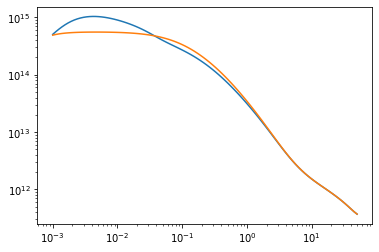

In [10]:
plt.loglog(rbin,deltaSigmaDMB)
plt.loglog(rbin,deltaSigmaDMO)

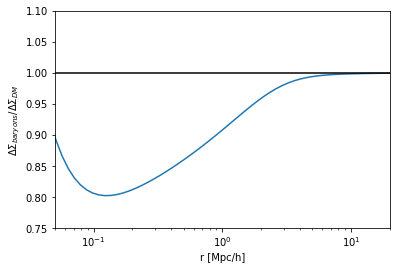

In [12]:
plt.semilogx(rbin, ratio)
plt.axhline(1, color='k')
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$\Delta \Sigma_{baryons} / \Delta \Sigma_{DM}$')
plt.ylim([0.75,1.1])
plt.xlim([0.05,20])
plt.show()

Note: shape of profiles and ratios very dependent on choice of bins

In [15]:
def ratio_given_rbin(rbin, label):
    cosmo_corr = splev(rbin,corr_tck)
    frac, dens, mass = bfc.profiles(rbin,Mv,cv,Mc,mu,thej,cosmo_corr,cosmo_bias,par)
    deltaSigmaDMB, deltaSigmaDMO, ratio = DeltaSigmas_from_density_profile(rbin,dens)
    plt.semilogx(rbin, ratio, label=label)

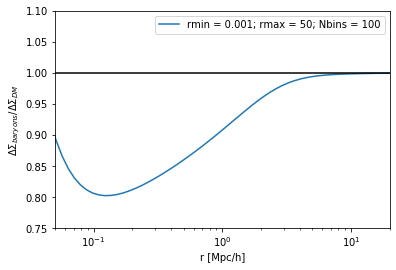

In [17]:
N_rbin = 100
rmin = 0.001
rmax = 50 

rbin = np.logspace(np.log10(rmin),np.log10(rmax),N_rbin,base=10)
label = 'rmin = {0}; rmax = {1}; Nbins = {2}'.format(rmin, rmax, N_rbin)

ratio_given_rbin(rbin, label)

plt.axhline(1, color='k')
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$\Delta \Sigma_{baryons} / \Delta \Sigma_{DM}$')
plt.ylim([0.75,1.1])
plt.xlim([0.05,20])
plt.legend()
plt.show()

# vary rmin


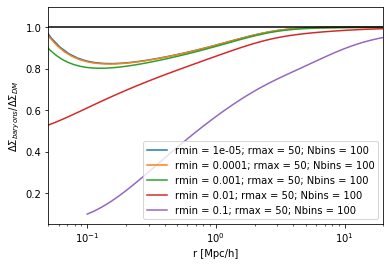

In [26]:
N_rbin = 100
rmin = 0.001
rmax = 50 

for rmin in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
    rbin = np.logspace(np.log10(rmin),np.log10(rmax),N_rbin,base=10)
    label = 'rmin = {0}; rmax = {1}; Nbins = {2}'.format(rmin, rmax, N_rbin)

    ratio_given_rbin(rbin, label)

plt.axhline(1, color='k')
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$\Delta \Sigma_{baryons} / \Delta \Sigma_{DM}$')
plt.ylim([0.05,1.1])
plt.xlim([0.05,20])
plt.legend()
plt.show()

# vary rmax 

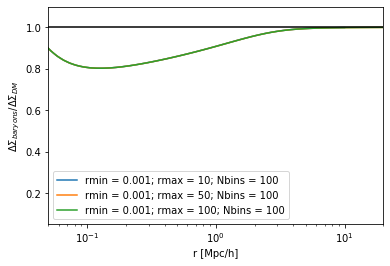

In [21]:
N_rbin = 100
rmin = 0.001
rmax = 50 

for rmax in [10, 50, 100]:
    rbin = np.logspace(np.log10(rmin),np.log10(rmax),N_rbin,base=10)
    label = 'rmin = {0}; rmax = {1}; Nbins = {2}'.format(rmin, rmax, N_rbin)

    ratio_given_rbin(rbin, label)

plt.axhline(1, color='k')
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$\Delta \Sigma_{baryons} / \Delta \Sigma_{DM}$')
plt.ylim([0.05,1.1])
plt.xlim([0.05,20])
plt.legend()
plt.show()

# vary N_rbin

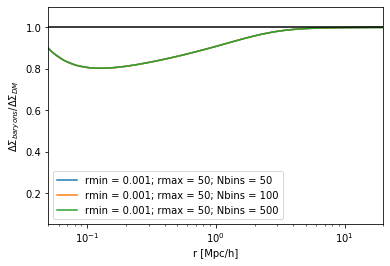

In [23]:
N_rbin = 100
rmin = 0.001
rmax = 50 

for N_rbin in [50, 100, 500]:
    rbin = np.logspace(np.log10(rmin),np.log10(rmax),N_rbin,base=10)
    label = 'rmin = {0}; rmax = {1}; Nbins = {2}'.format(rmin, rmax, N_rbin)

    ratio_given_rbin(rbin, label)

plt.axhline(1, color='k')
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$\Delta \Sigma_{baryons} / \Delta \Sigma_{DM}$')
plt.ylim([0.05,1.1])
plt.xlim([0.05,20])
plt.legend()
plt.show()